In [87]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PyEMD import EMD
from nolitsa import dimension
from mpl_toolkits import mplot3d
%matplotlib notebook

In [17]:
def read_data():

    """ Read all data from bearing B11 and store in data_B11 list """
    folder_path = '../FEMTOBearingDataSet/Learning_set/Bearing1_1/'
    test = pd.DataFrame()
    for i in range(2550, 2600):
        f_num = str(i).rjust(5, '0')
        test = test.append(pd.read_csv(folder_path + 'acc_{}.csv'.format(f_num),
                        names=['hora', 
                                 'minuto', 
                                 'segundo', 
                                 'm_sec', 
                                 'h_acc', 
                                 'v_acc']))
    return test

In [18]:
df = read_data()

In [19]:
df.head()

,hora,minuto,segundo,m_sec,h_acc,v_acc
0,16,44,29,65664.0,-0.051,0.485
1,16,44,29,65703.0,0.243,0.263
2,16,44,29,65742.0,-0.796,-0.071
3,16,44,29,65781.0,-1.389,1.160
4,16,44,29,65820.0,-1.057,-0.959


In [20]:
v_acc = np.array(df.v_acc)
del df

In [21]:
emd = EMD()
res = emd(v_acc)
res

array([[ 0.08669708, -0.42972308, -0.77237555, ...,  0.9416091 ,
        -0.93769389,  0.06269966],
       [ 0.18027304,  0.54053396,  0.57639059, ..., -0.48756644,
         0.69839923, -0.09460803],
       [ 0.00897277, -0.10017182, -0.12592783, ..., -0.06913043,
        -0.11693392, -0.11222918],
       ...,
       [-0.01046571, -0.01046592, -0.01046614, ...,  0.00504379,
         0.00504308,  0.00504236],
       [-0.00194298, -0.00194302, -0.00194306, ...,  0.00534363,
         0.00534351,  0.00534338],
       [ 0.00877439,  0.00877438,  0.00877437, ...,  0.00816134,
         0.00816136,  0.00816138]])

In [22]:
imfs, res = emd.get_imfs_and_residue()

In [23]:
imfs.shape

(18, 128000)

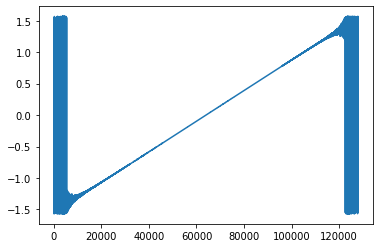

In [30]:
# for i in range(0, 16):
coef = np.fft.fft(imfs[8])
phases = np.arctan(np.imag(coef)/np.real(coef))
plt.plot(phases)

## A partir da IMF 7, temos comportamento determinístico

In [31]:
stochastic = np.sum(imfs[:8], axis=0)
deterministic = np.sum(imfs[8:], axis=0) + res

In [32]:
deterministic.shape

(128000,)

In [33]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[len(result)//2:]

107

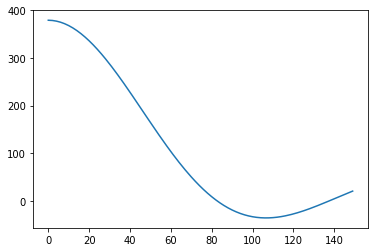

In [37]:
auto = autocorr(deterministic)[:150]
plt.plot(auto)
# Find index of mininum value
tau = np.argmin(auto)
tau

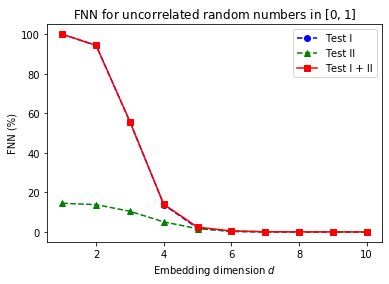

In [38]:
dim = np.arange(1, 10 + 1)
f1, f2, f3 = dimension.fnn(deterministic, tau=tau, dim=dim, window=3, metric='euclidean')
plt.title(r'FNN for uncorrelated random numbers in $[0, 1]$')
plt.xlabel(r'Embedding dimension $d$')
plt.ylabel(r'FNN (%)')
plt.plot(dim, 100 * f1, 'bo--', label=r'Test I')
plt.plot(dim, 100 * f2, 'g^--', label=r'Test II')
plt.plot(dim, 100 * f3, 'rs-', label=r'Test I + II')
plt.legend()

plt.show()

In [79]:
def embedd(series, d, m):
    res = pd.DataFrame(series[:~(m*d)])
    emd = pd.DataFrame(series)
    for col in range(1, m+1):
        aux = emd.shift(-(d*col), axis=0)
        res['m_{}'.format(col*d)] = aux
    return res

In [85]:
test = [x for x in range(0, 50)]
emd = embedd(deterministic, d=107, m=5)
emd.head()

,0,m_107,m_214,m_321,m_428,m_535
0,0.008441,-0.000189,0.012856,0.026846,0.015105,0.089498
1,0.008611,-0.000203,0.012840,0.027902,0.011514,0.095119
2,0.008776,-0.000211,0.012820,0.028976,0.007887,0.100648
3,0.008936,-0.000213,0.012794,0.030067,0.004230,0.106070
4,0.009092,-0.000209,0.012765,0.031175,0.000548,0.111371


<IPython.core.display.Javascript object>


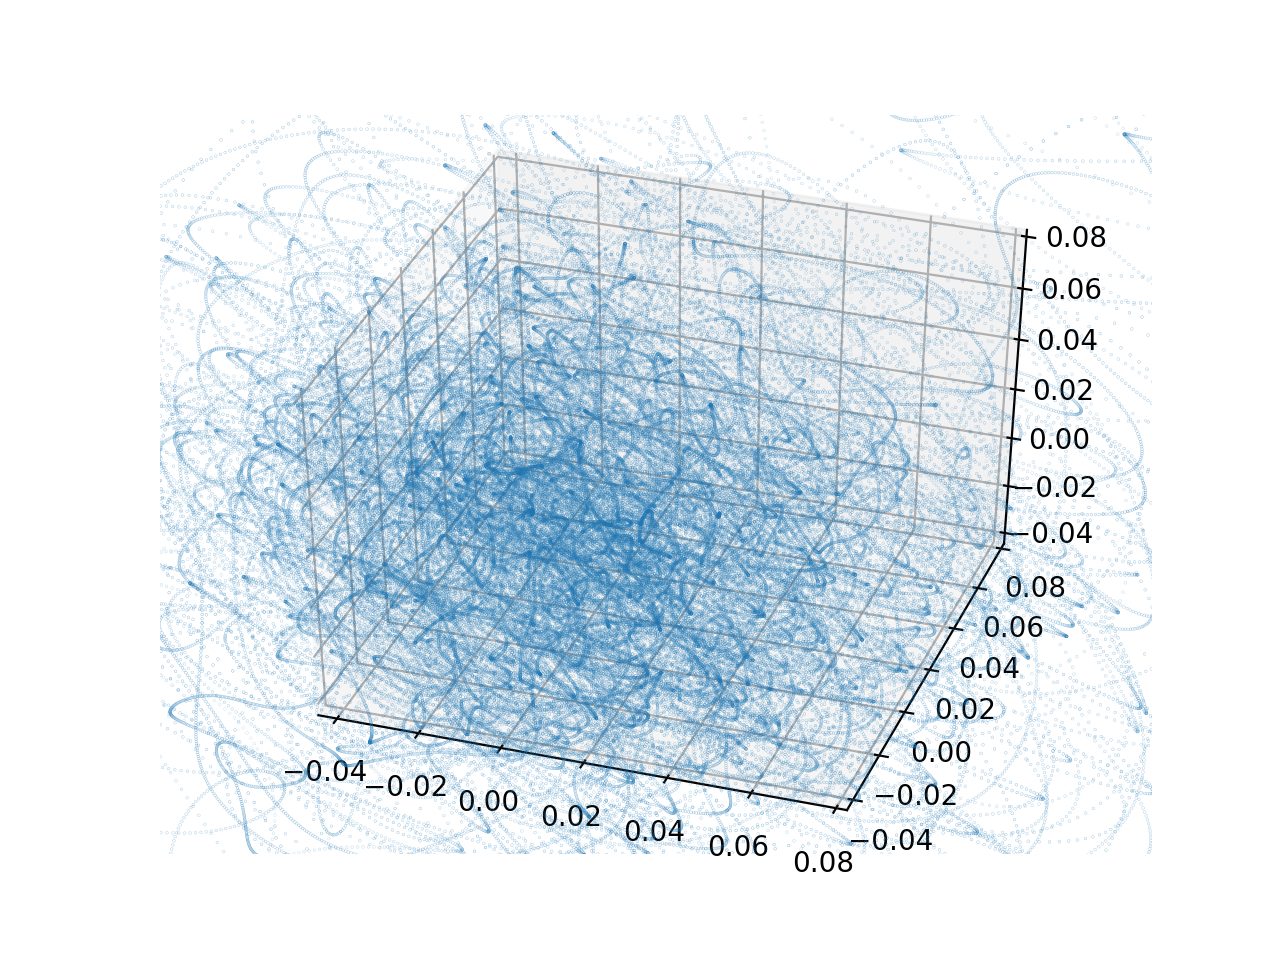

In [92]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(emd[0], emd['m_107'], emd['m_214'], s=0.01)